# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

Opening the 

In [2]:
import sys
sys.path.append('../functions/')

import load_dataset as load
from importlib import reload
import phase_calc_functions as phase_calc

import phase_plot_functions as phase_plot

In [3]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
len(awap.time.values), len(rmm.time.values)

(7874, 7874)

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5">  Calculatoin </font></center></div>

In [4]:
# Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
# this was not done it would be the end half of one wet season and the start of another. This moves that data
# from the start of the wet season back or forwards a year (I don't remember), so that they line up

phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [5]:
awap_split_ws

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9, time: 7767)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2018-12-31
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [6]:
# Below the file gets overrided into an extreme file, this is for emergencies
awap_split_ws_origonal = awap_split_ws.copy(deep = True)

In [7]:
awap_split_ws = awap_split_ws_origonal

In [8]:
# The same functions below apply for extreme rainfall. Just changing the rainfall to only extremes here.
# THe ex-piece adds on to the tile, so they don't get saved as the same name
extreme = 0
if extreme:
    q = 95
    threshold = awap_split_ws.reduce(np.nanpercentile, dim = 'time', q = q)
    awap_split_ws = awap_split_ws.where(awap_split_ws.precip >= threshold.precip)
    ex_piece = f'{q}th_percentile'
else:
    ex_piece = ''

In [9]:
# Removign the points outside of a range that is too big
def max_filter(data, vmax):
    data = data.where(data.trend < vmax, vmax - 0.01)
    data = data.where(data.trend > -vmax, -vmax + 0.01)
    
    from miscellaneous import apply_masks
    data = apply_masks(data)
    
    return data
    

# Count

## Calculation

Counting the number of days in each year in each phase

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

<b> Phases </b>

In [10]:
awap_count = awap_split_ws.resample(time = 'y').count(dim = 'time')
awap_count['time'] = awap_count.time.dt.year
awap_count = awap_count.rename({'time':'year'})

Thses are the actual functions that calculated the trend

In [11]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count, trend_sig_count, trend_percent_count, trend_percent_sig_count = \
    phase_calc.return_alltrendinfo_custom(awap_count.precip)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


In [15]:
# Trend that is normalised by the number of days in each phase

phase_calc = reload(phase_calc)
trend_count_norm, trend_sig_count_norm, trend_percent_count_norm, trend_percent_sig_count_norm = \
    phase_calc.return_alltrendinfo_custom(awap_count.precip, normalise = 'phase')

47
---
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


<b> The subphases </b>

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases </font></center></div>

In [16]:
enhanced = awap_count.sel(phase = ['5','6','7']).sum(dim = 'phase')
suppressed = awap_count.sel(phase = ['1','2','3']).sum(dim = 'phase')
transition = awap_count.sel(phase = ['4','8']).sum(dim = 'phase')
inacitve = awap_count.sel(phase = 'inactive').drop('phase')

awap_count_sub = xr.concat([enhanced, suppressed, transition, inacitve], 
                           pd.Index(['enhanced', 'suppressed' ,'transition', 'inactive'], name = 'phase'))

In [17]:
awap_count_sub 

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, year: 44)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) int64 0 5 5 6 4 4 4 4 6 ... 0 0 0 0 0 0 0 0

In [ ]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count_sub, trend_sig_count_sub, trend_percent_count_sub, trend_percent_sig_count_sub = \
    phase_calc.return_alltrendinfo_custom(awap_count_sub.precip)

In [18]:
# Trend that is normalised by the number of days in each phase

phase_calc = reload(phase_calc)
trend_count_sub_norm, trend_sig_count_sub_norm, trend_percent_count_sub_norm, trend_percent_sig_count_sub_norm = \
    phase_calc.return_alltrendinfo_custom(awap_count_sub.precip, normalise = 'subphase')

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


## Plots

In [20]:
savedir = 'trends/awap/'

In [21]:
import trend_plot_2 as tp2

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [502]:
# Making sure that it is on either side of the bounds, this trend is too big
trend_percent_count_sub = max_filter(trend_percent_count_sub, 60)

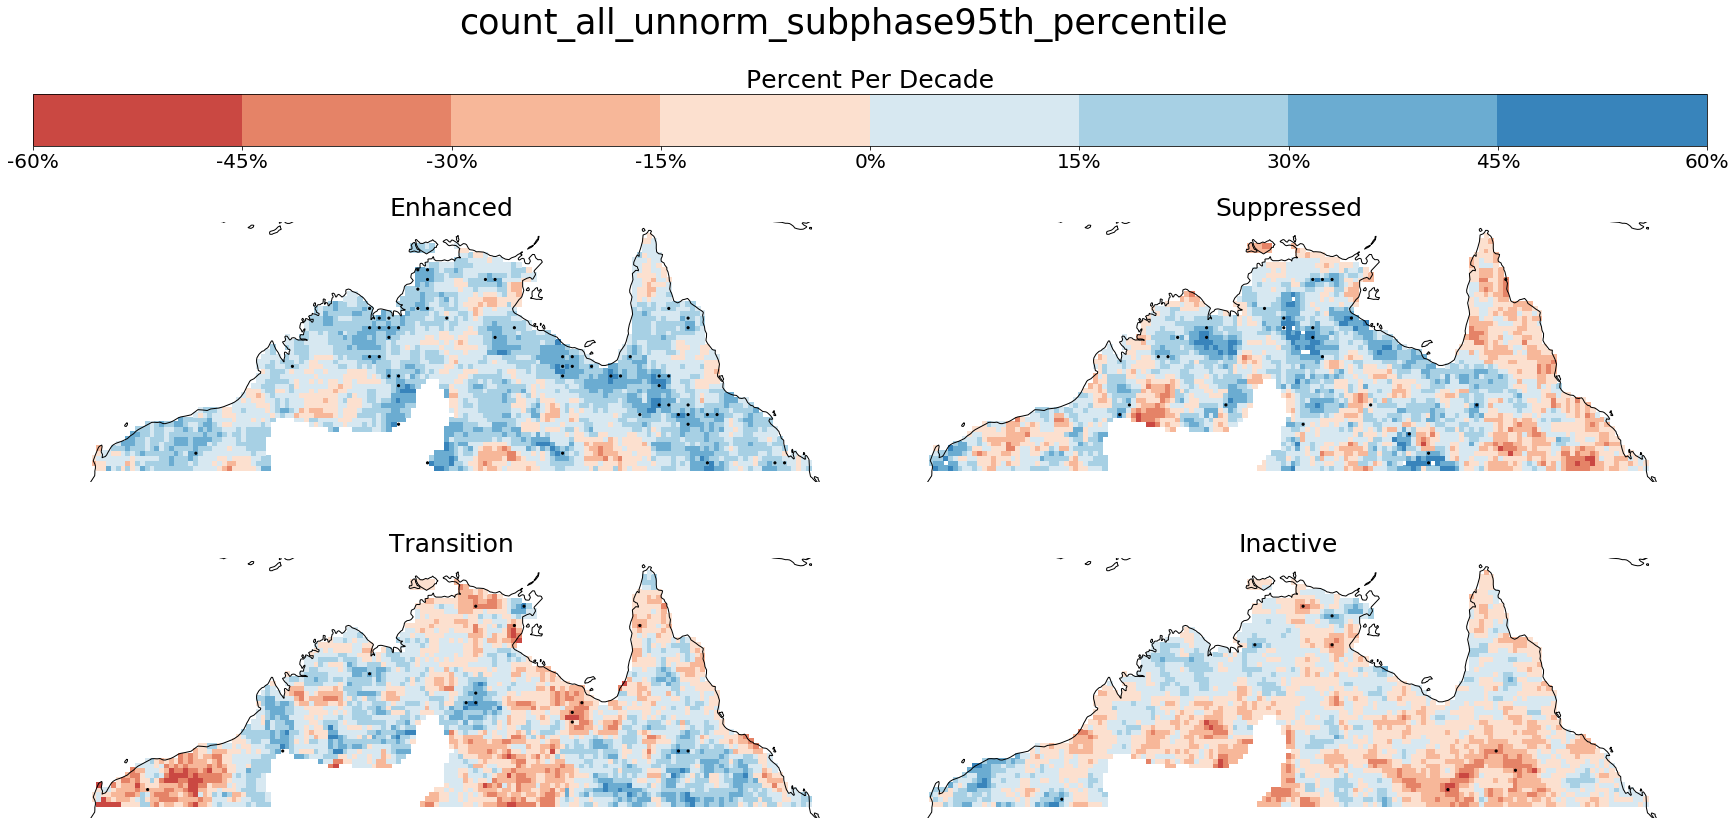

In [503]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_count_sub.trend, stip_data = trend_percent_sig_count_sub.trend,
               vmax = 40, step = 10, sig_size = 4.5,
               title = 'count_all_unnorm_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade') 
#                ,savedir = savedir)

In [514]:
# Making sure that it is on either side of the bounds, this trend is too big
trend_percent_count_sub_norm = max_filter(trend_percent_count_sub_norm, 60)

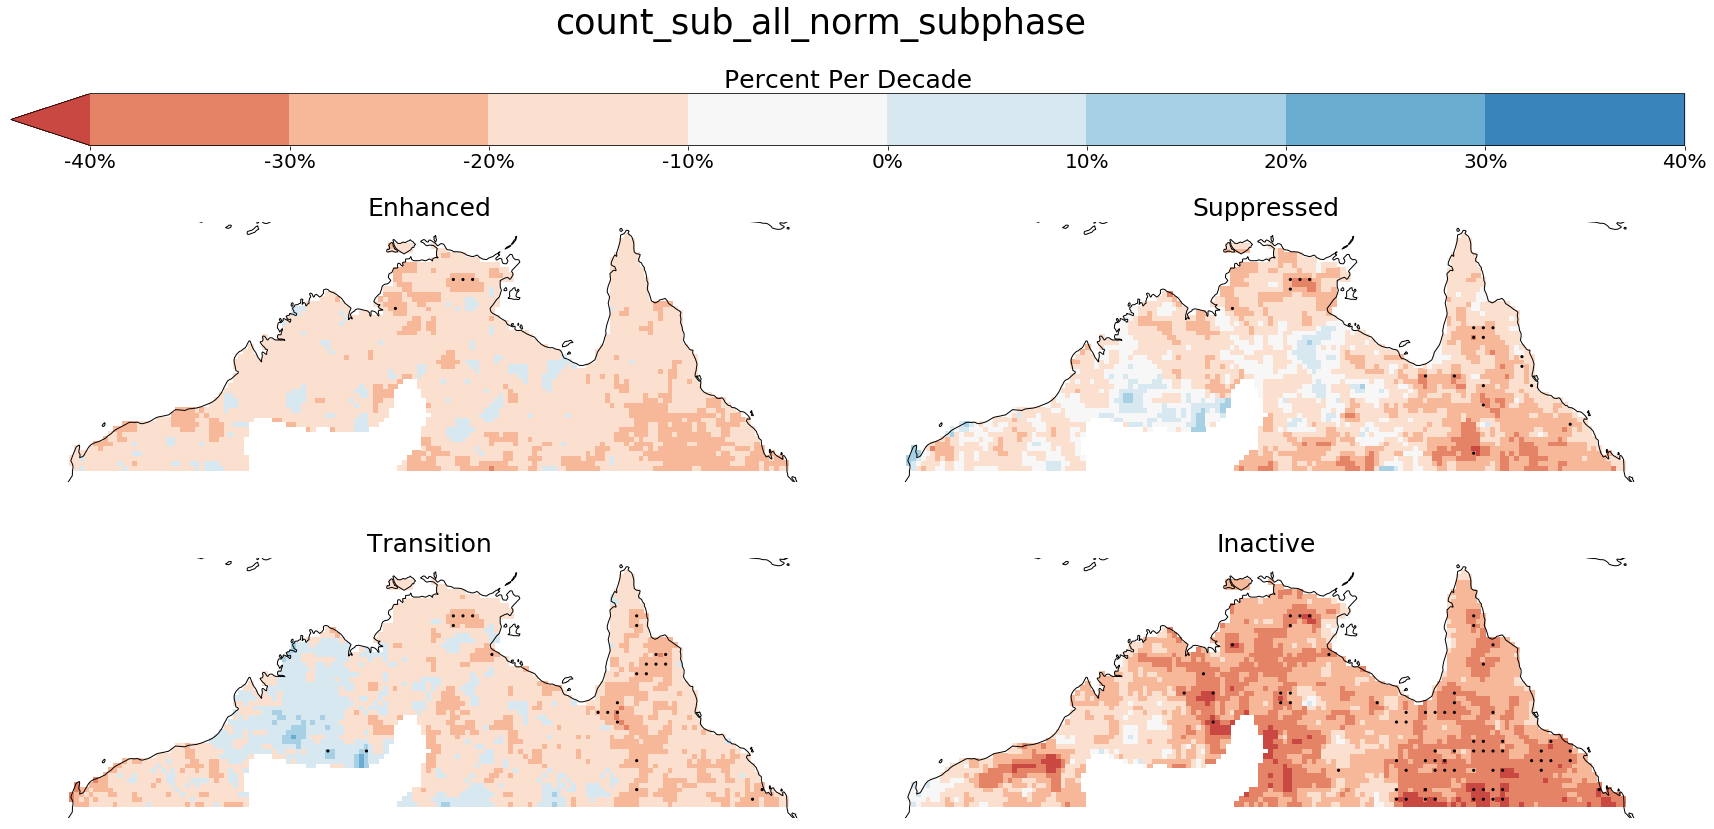

In [22]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_count_sub_norm.trend, stip_data = trend_percent_sig_count_sub_norm.trend,
               vmax = 40, step = 10, sig_size = 4.5,
               title = 'count_sub_all_norm_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade')
#                ,savedir = savedir)

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

In [516]:
trend_percent_count = max_filter(trend_percent_count, 60)

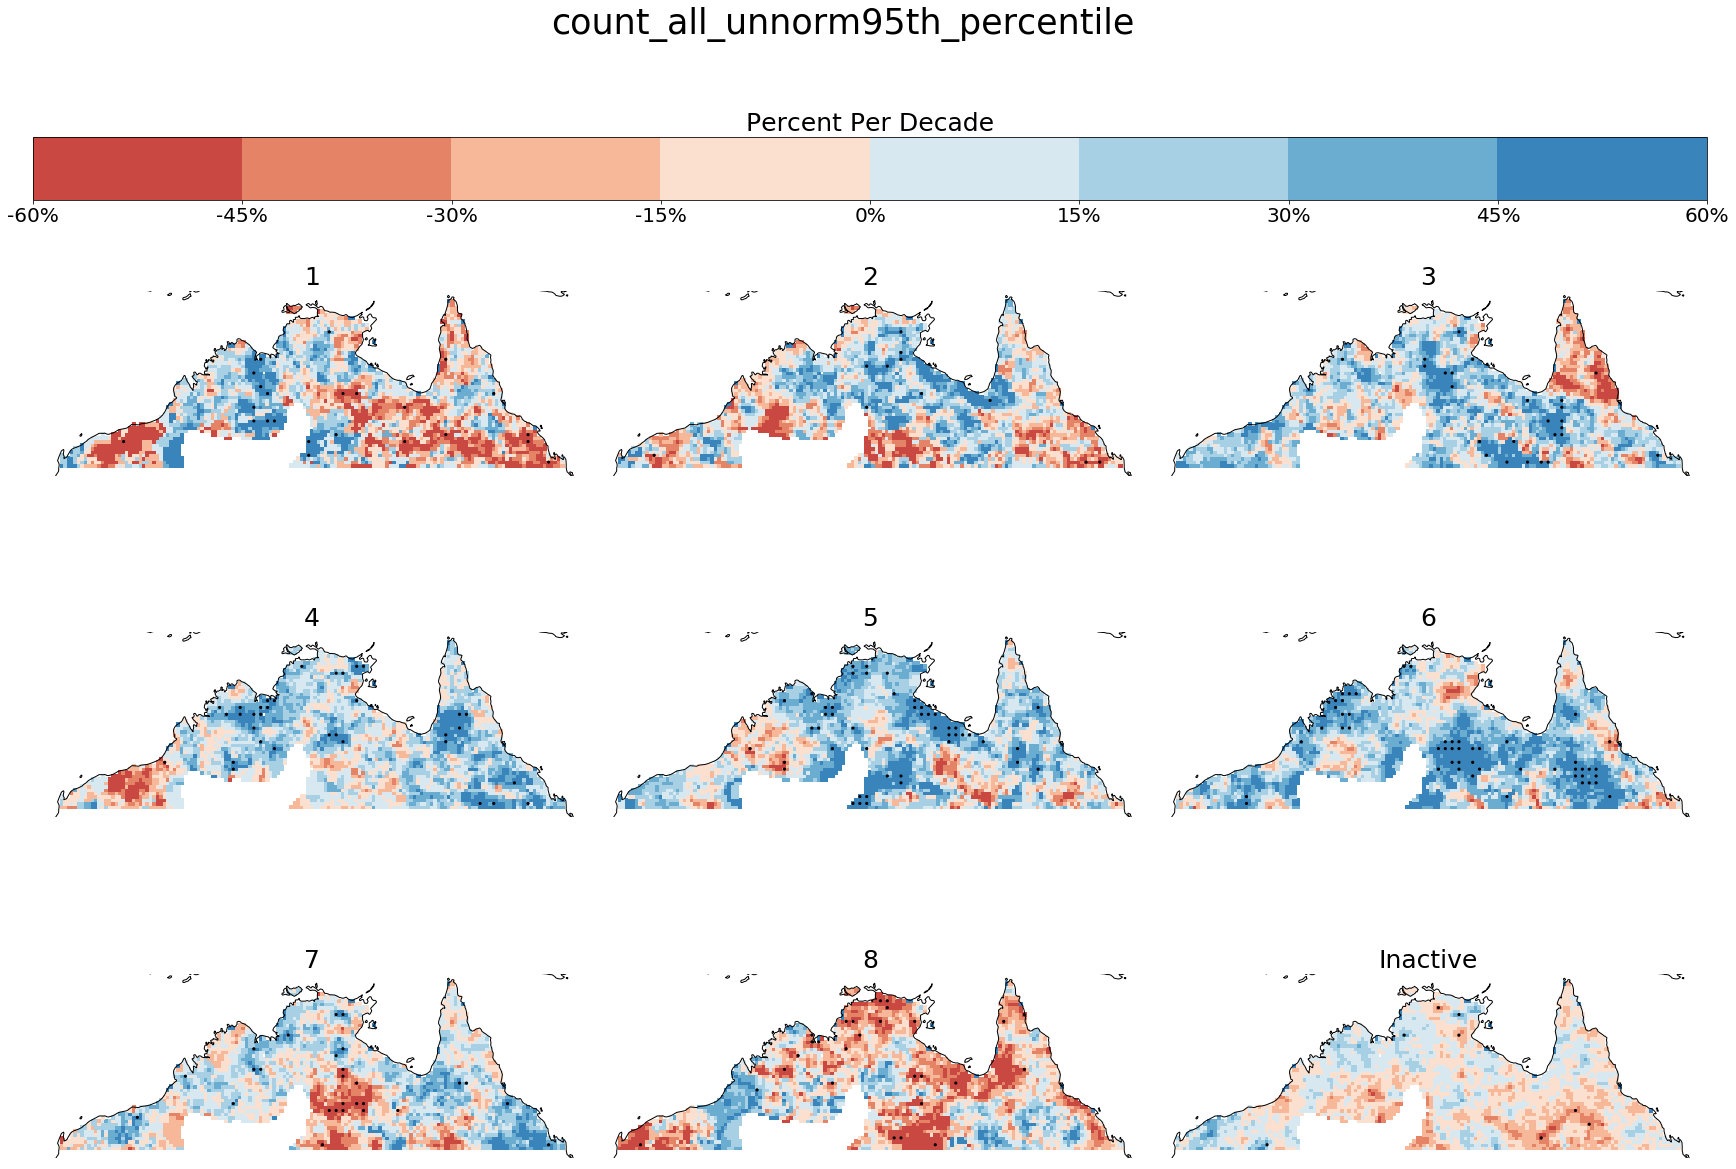

In [518]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_count.trend, stip_data = trend_percent_sig_count.trend,
                vmax = 60, step = 15, sig_size = 4.5,
               title = 'count_all_unnorm'+ ex_piece, colorbar_title = 'Percent Per Decade')

In [519]:
trend_percent_count_norm = max_filter(trend_percent_count_norm, 60)

In [ ]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_count_norm.trend, stip_data = trend_percent_sig_count_norm.trend, 
                vmax = 50, step = 10, sig_size = 4.5,
               title = 'count_all_norm'+ ex_piece, colorbar_title = 'Percent Per Decade')
#                ,savedir = savedir)

# Sum

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

In [473]:
def awap_resample_sum(awap):
    awap_resampled = awap.resample(time = 'y').sum(dim = 'time')
    awap_resampled['time'] = awap_resampled.time.dt.year
    awap_resampled = awap_resampled.rename({'time':'year'})
    
    return awap_resampled

In [474]:
prop = 0
if prop:
    # The sum of the non_extreme
    awap_sum_rainfall = awap_resample_sum(awap_split_ws_origonal)
    awap_sum_extreme= awap_resample_sum(awap_split_ws)
    
    awap_sum = awap_sum_extreme/awap_sum_rainfall
    
    prop_piece = '_proportion_'
else:
    
    awap_sum_rainfall = awap_resample_sum(awap_split_ws_origonal)
    
    
    prop_piece = ''

In [475]:
awap_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    precip   (year, phase, lat, lon) float32 nan 0.0 0.0 0.0 ... nan nan nan nan

In [476]:
phase_calc = reload(phase_calc)
trend_sum, trend_sig_sum, trend_percent_sum, trend_percent_sig_sum = \
    phase_calc.return_alltrendinfo_custom(awap_sum.precip)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


In [477]:
phase_calc = reload(phase_calc)
trend_sum_norm, trend_sig_sum_norm, trend_percent_sum_norm, trend_percent_sig_sum_norm = \
    phase_calc.return_alltrendinfo_custom(awap_sum.precip, normalise = 'phase')

46
---
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [478]:
# Another index that I want to look at it the proportion of rainfall falling as extreme. If prop == 1, then
# this makes the proportion, rather than jus the total rainfll the subject. The proportion is only
# available for extreme rainfall

if prop:
    enhanced = awap_sum_extreme.sel(phase = ['5','6','7']).sum(dim = 'phase')
    suppressed = awap_sum_extreme.sel(phase = ['1','2','3']).sum(dim = 'phase')
    transition = awap_sum_extreme.sel(phase = ['4','8']).sum(dim = 'phase')
    inacitve = awap_sum_extreme.sel(phase = 'inactive').drop('phase')
    
    awap_sum_sub_extreme = xr.concat([enhanced, suppressed, transition, inacitve], 
                           pd.Index(['enhanced', 'suppressed' ,'transition', 'inactive'], name = 'phase'))
    
    enhanced = awap_sum_rainfall.sel(phase = ['5','6','7']).sum(dim = 'phase')
    suppressed = awap_sum_rainfall.sel(phase = ['1','2','3']).sum(dim = 'phase')
    transition = awap_sum_rainfall.sel(phase = ['4','8']).sum(dim = 'phase')
    inacitve = awap_sum_rainfall.sel(phase = 'inactive').drop('phase')

    awap_sum_sub_rainfall = xr.concat([enhanced, suppressed, transition, inacitve], 
                               pd.Index(['enhanced', 'suppressed' ,'transition', 'inactive'], name = 'phase'))

    prop_piece = '_proportion_'
    
    awap_sum_sub = awap_sum_sub_extreme /awap_sum_sub_rainfall
    
else:
    enhanced = awap_sum.sel(phase = ['5','6','7']).sum(dim = 'phase')
    suppressed = awap_sum.sel(phase = ['1','2','3']).sum(dim = 'phase')
    transition = awap_sum.sel(phase = ['4','8']).sum(dim = 'phase')
    inacitve = awap_sum.sel(phase = 'inactive').drop('phase')

    awap_sum_sub = xr.concat([enhanced, suppressed, transition, inacitve], 
                               pd.Index(['enhanced', 'suppressed' ,'transition', 'inactive'], name = 'phase'))

    prop_piece = ''

In [479]:
phase_calc = reload(phase_calc)
trend_sum_sub, trend_sig_sum_sub, trend_percent_sum_sub, trend_percent_sig_sum_sub = \
    phase_calc.return_alltrendinfo_custom(awap_sum_sub.precip)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


In [480]:
phase_calc = reload(phase_calc)
trend_sum_sub_norm, trend_sig_sum_sub_norm, trend_percent_sum_sub_norm, trend_percent_sig_sum_sub_norm = \
    phase_calc.return_alltrendinfo_custom(awap_sum_sub.precip, normalise = 'subphase')

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


## Plots

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

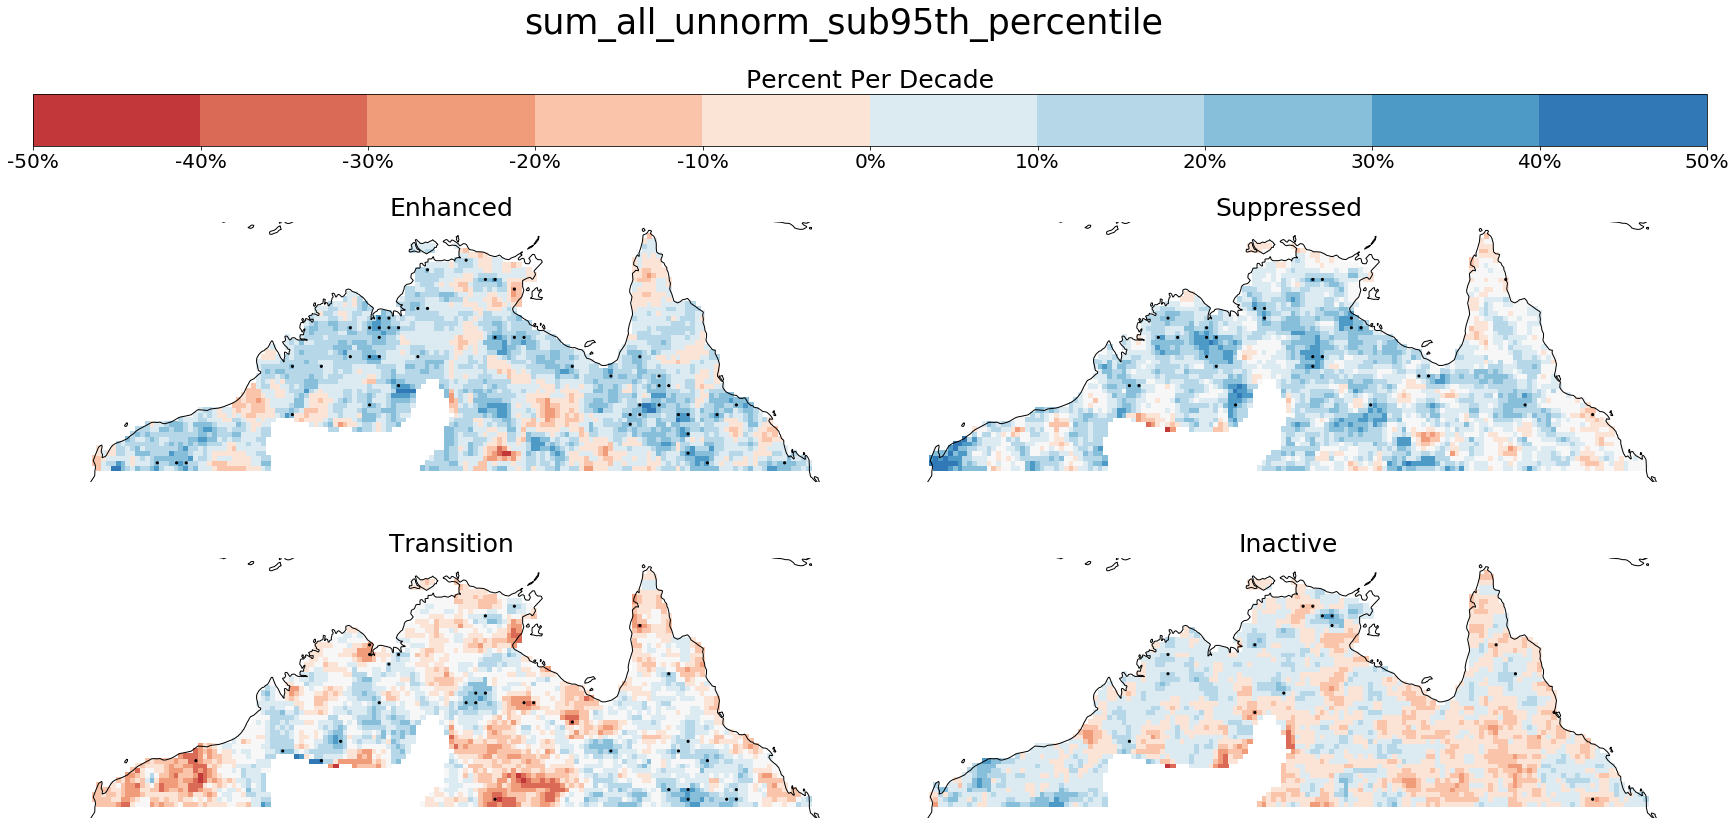

In [481]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_sum_sub.trend, stip_data = trend_percent_sig_sum_sub.trend,
                vmax = 50, step = 10, sig_size = 4.5,
               title = prop_piece + 'sum_all_unnorm_sub'+ ex_piece, colorbar_title = 'Percent Per Decade',
               savedir = savedir)

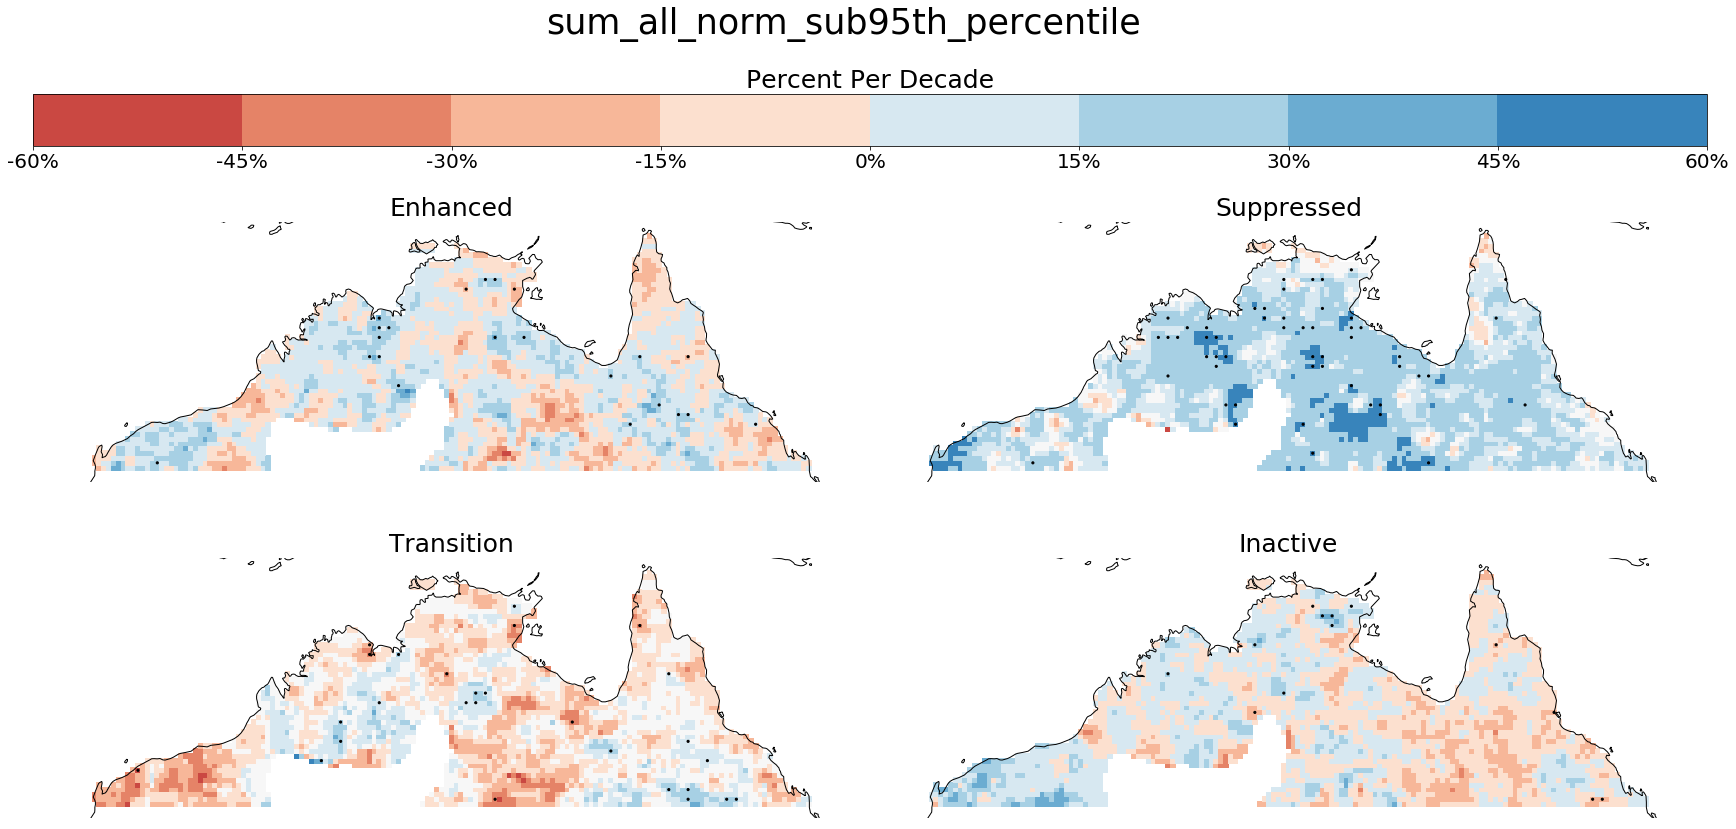

In [482]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_sum_sub_norm.trend, stip_data = trend_percent_sig_sum_sub_norm.trend,
               vmax = 60, step = 15, sig_size = 4.5,
               title = 'sum_all_norm_sub'+ ex_piece, colorbar_title = 'Percent Per Decade',
               savedir = savedir)

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

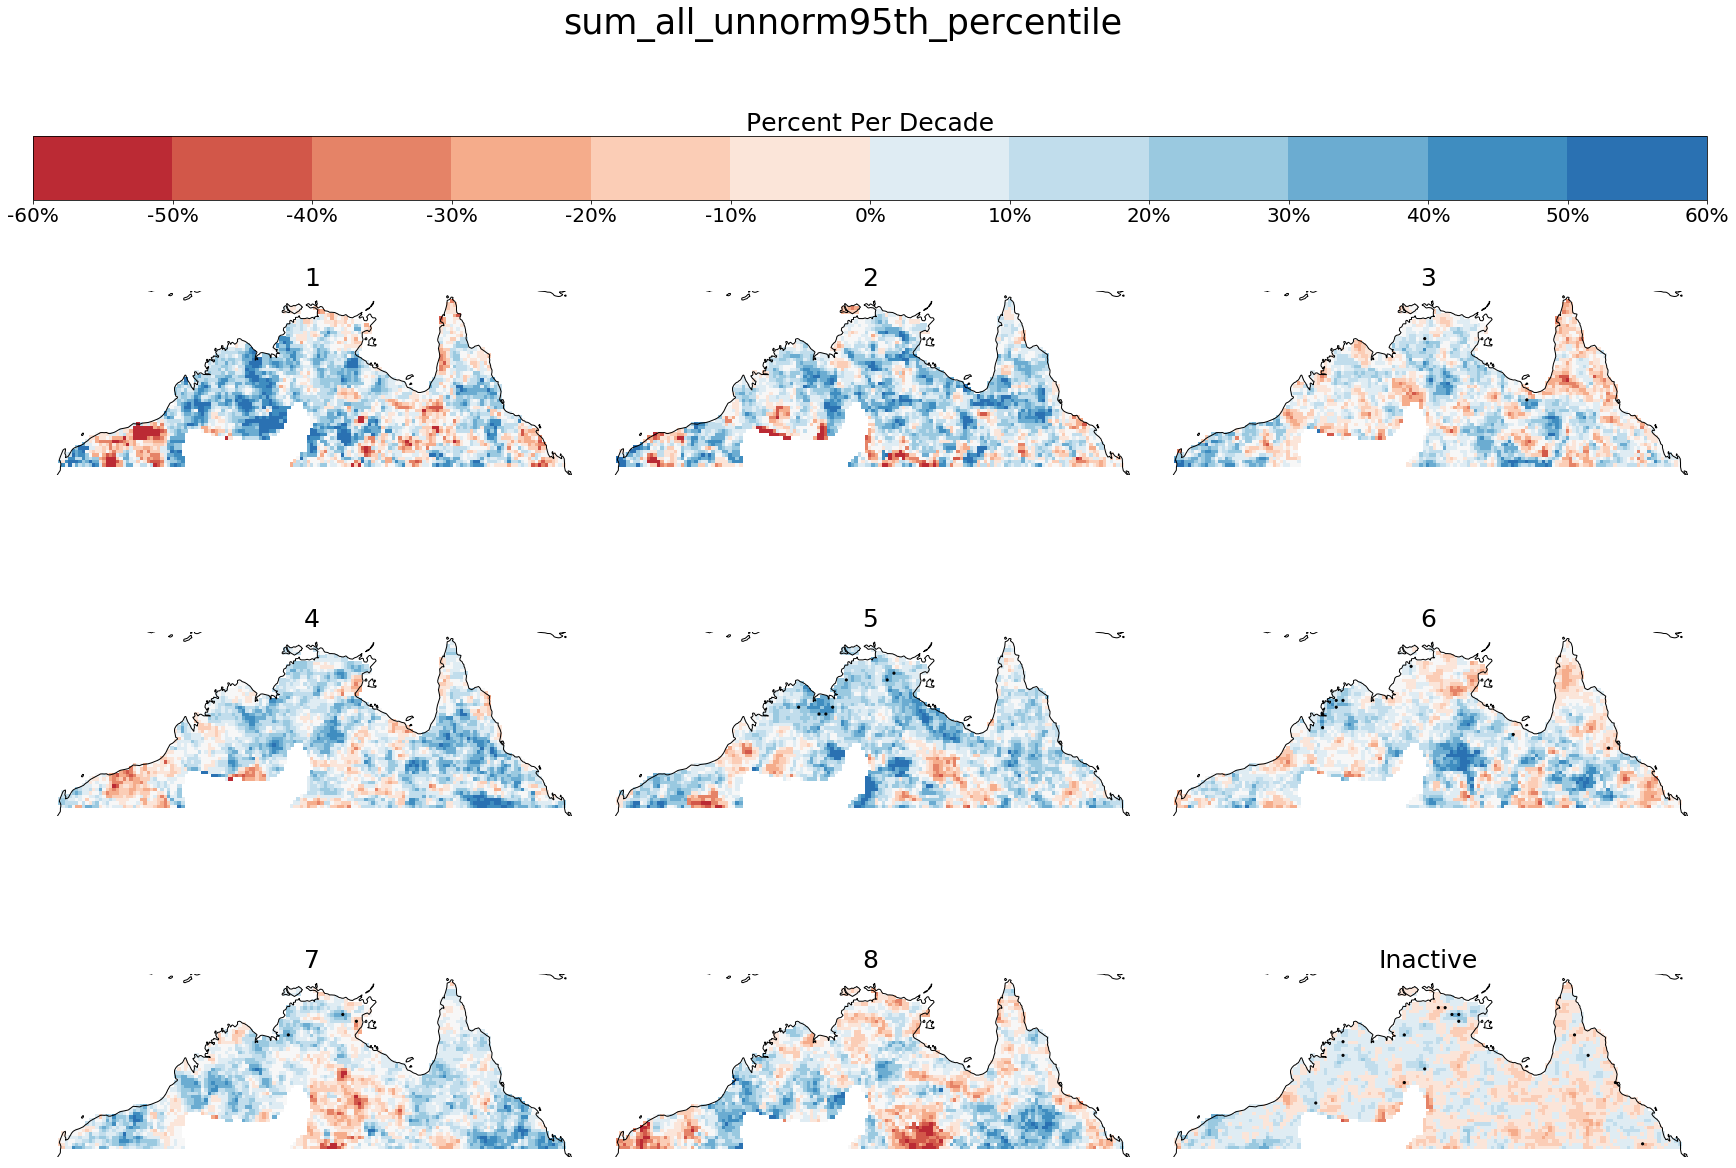

In [483]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_sum.trend, stip_data = trend_percent_sig_sum.trend,
               vmax = 60, step = 10, sig_size = 4.5,
               title = prop_piece + 'sum_all_unnorm'+ ex_piece, colorbar_title = 'Percent Per Decade',
               savedir = savedir)

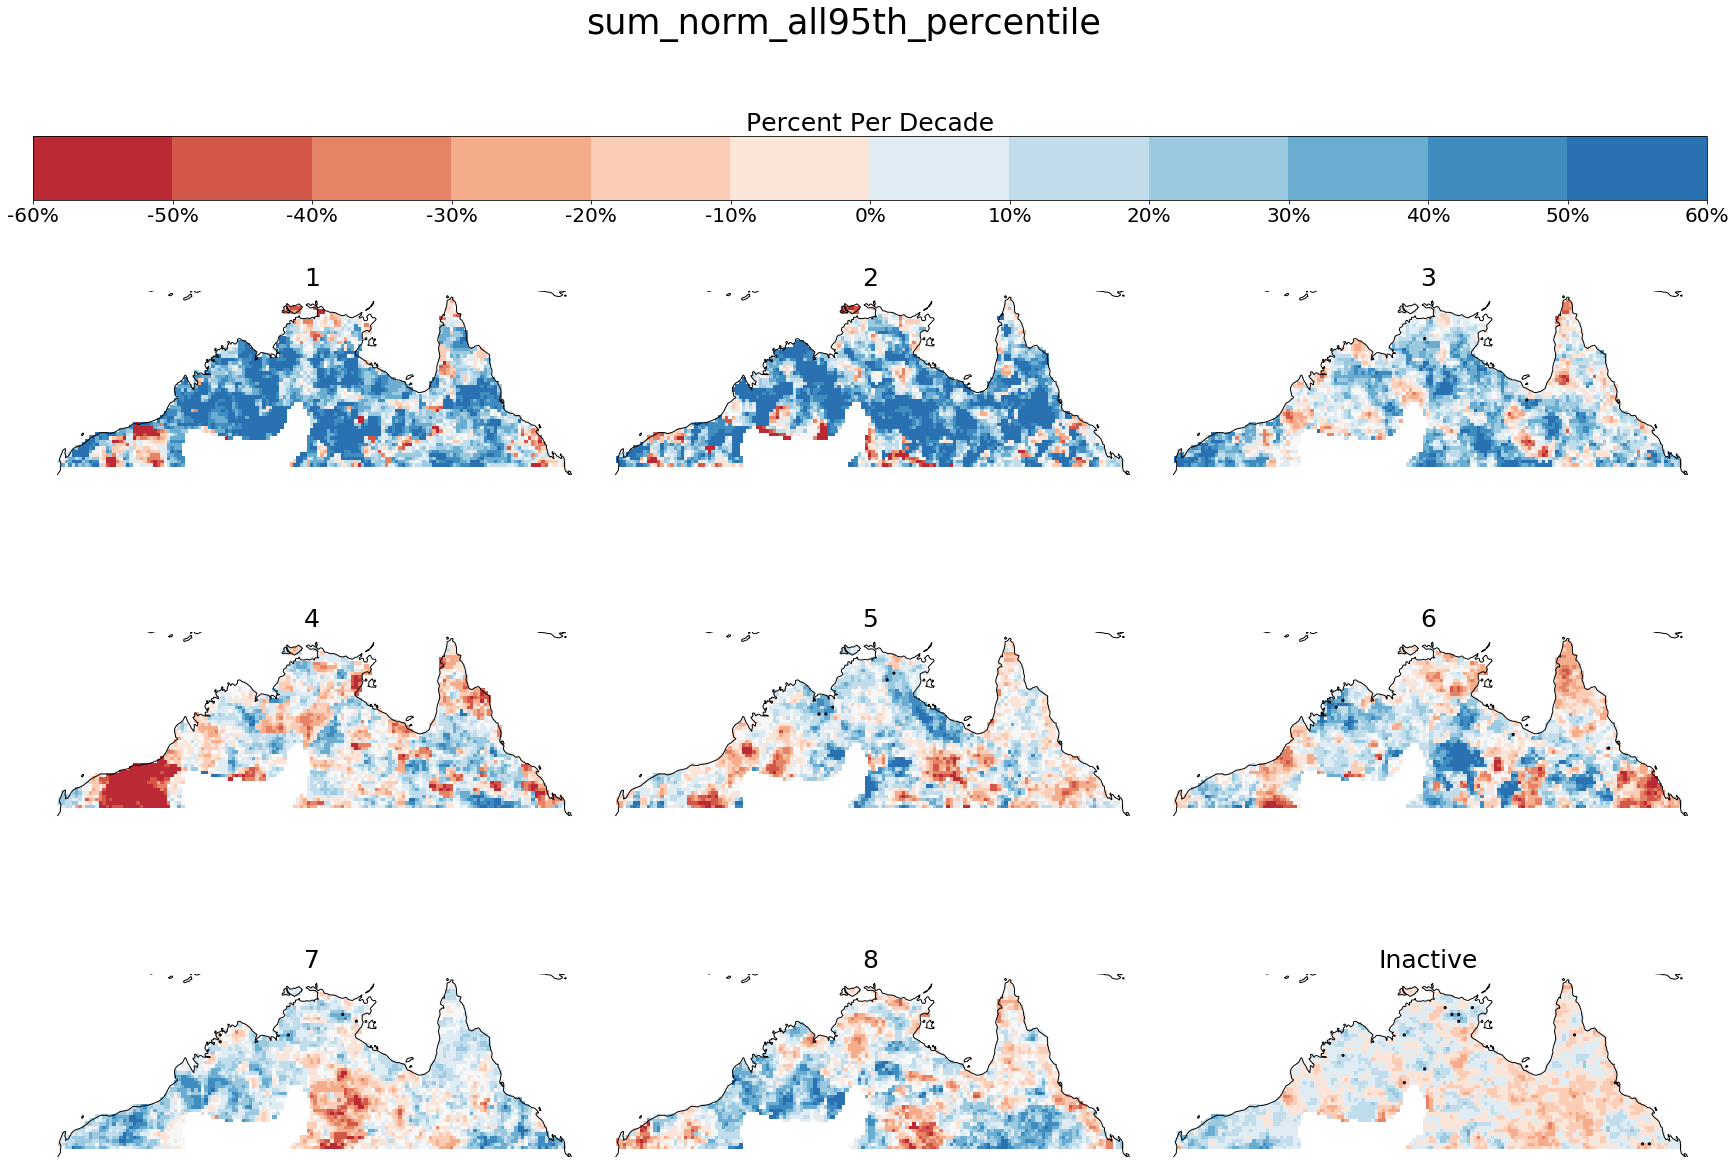

In [484]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_sum_norm.trend, stip_data = trend_percent_sig_sum_norm.trend,
               vmax = 60, step = 10,sig_size = 4.5,
               title = 'sum_norm_all'+ ex_piece, colorbar_title = 'Percent Per Decade',
                savedir = savedir)

# Intensity

## Calculation

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

In [485]:
awap_int = awap_split_ws.resample(time = 'y').mean(dim = 'time')
awap_int['time'] = awap_int.time.dt.year
awap_int = awap_int.rename({'time':'year'})

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [486]:
data = awap_split_ws
enhanced = data.sel(phase = '5').combine_first(data.sel(phase = '6')).combine_first(data.sel(phase = '7')).drop('phase')
suppressed = data.sel(phase = '1').combine_first(data.sel(phase = '2')).combine_first(data.sel(phase = '3')).drop('phase')
transition = data.sel(phase = '4').combine_first(data.sel(phase = '8'))
inactive = data.sel(phase = 'inactive').drop('phase')




awap_split_sub = xr.concat([enhanced, suppressed, transition, inactive], 
                           pd.Index(['enhanced', 'suppressed' ,'transition', 'inactive'], name = 'phase'))

In [487]:
awap_int_sub = awap_split_sub.resample(time = 'y').mean(dim = 'time')
awap_int_sub['time'] = awap_int_sub.time.dt.year
awap_int_sub = awap_int_sub.rename({'time':'year'})

## Plots

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Phases  </font></center></div>

In [488]:
phase_calc = reload(phase_calc)
trend_int, trend_sig_int, trend_percent_int, trend_percent_sig_int = \
    phase_calc.return_alltrendinfo_custom(awap_int.precip)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Subphases  </font></center></div>

In [489]:
phase_calc = reload(phase_calc)
trend_int_sub, trend_sig_int_sub, trend_percent_int_sub, trend_percent_sig_int_sub = \
    phase_calc.return_alltrendinfo_custom(awap_int_sub.precip)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


In [526]:
trend_percent_int_sub = max_filter(trend_percent_int_sub, 40)

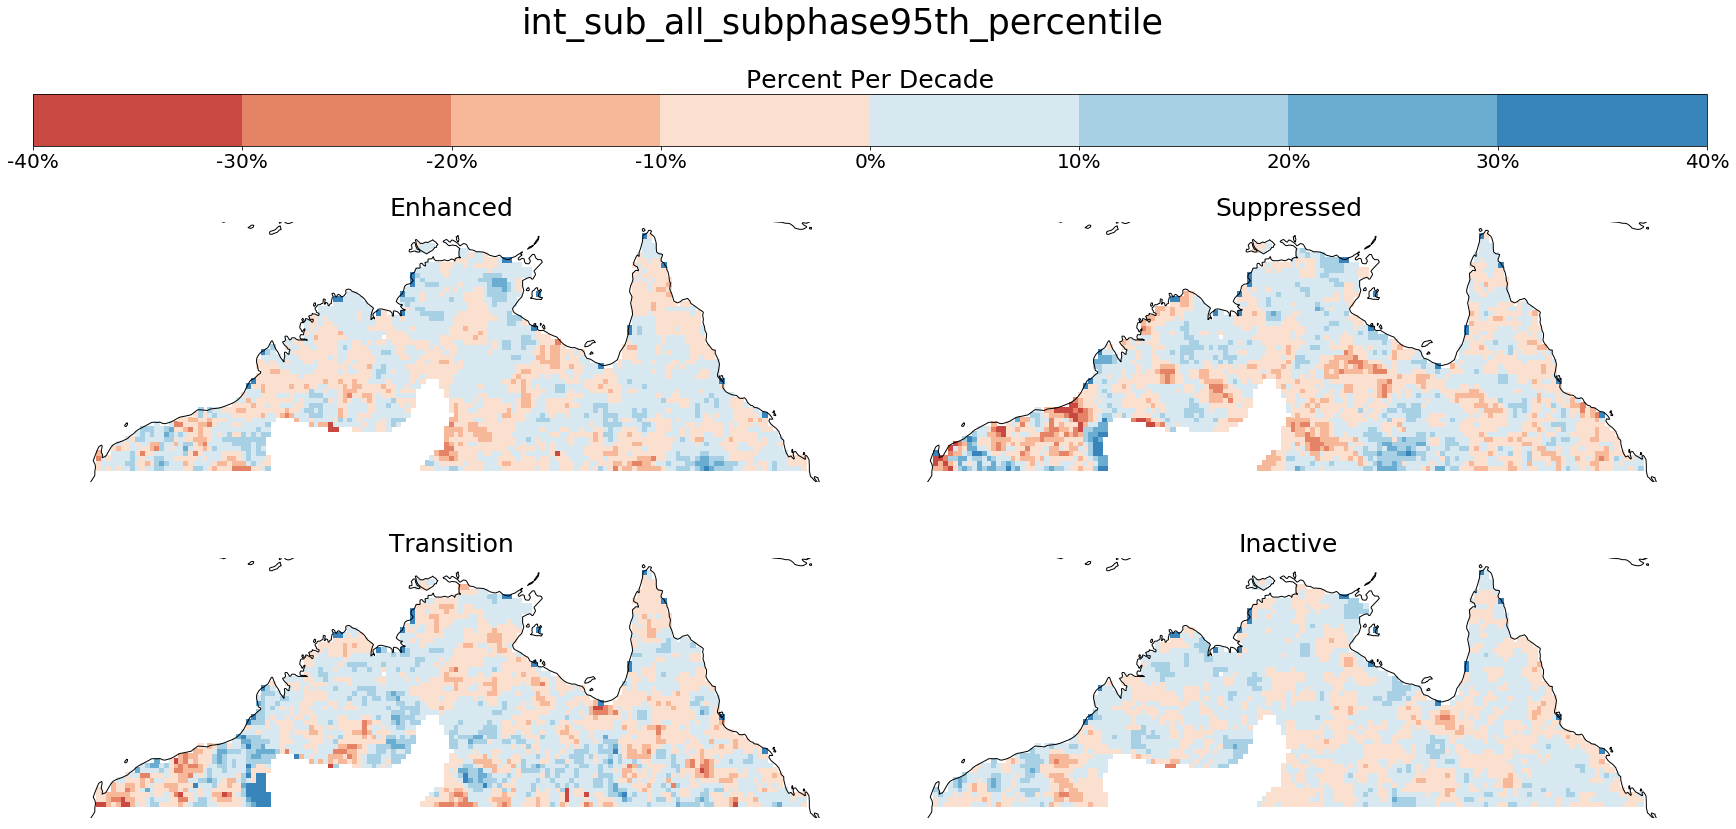

In [527]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_int_sub.trend, stip_data = trend_percent_sig_int_sub.trend,
                sig_size = 4.5, vmax = 40, step = 10, 
               title = 'int_sub_all_subphase'+ ex_piece, colorbar_title = 'Percent Per Decade',
               savedir = savedir)

In [528]:
trend_percent_int = max_filter(trend_percent_int, 40)

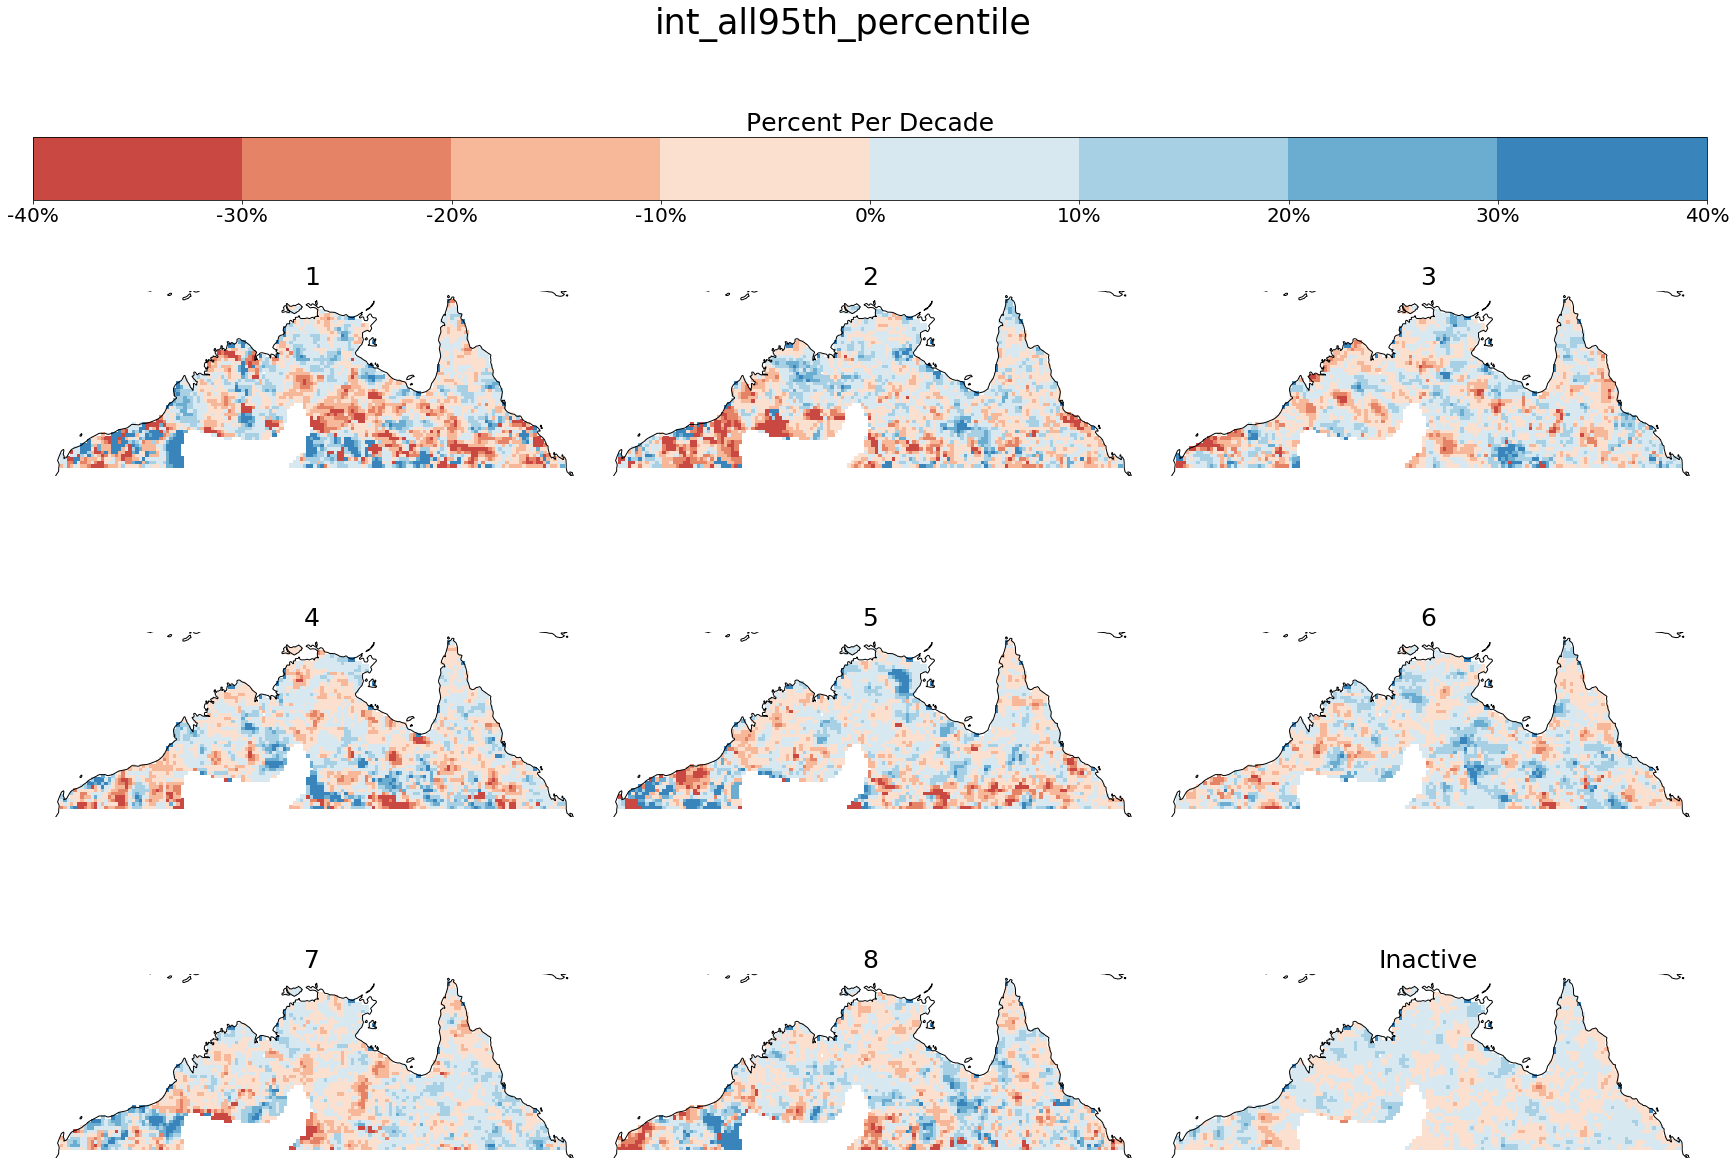

In [529]:
tp2 = reload(tp2)
tp2.trend_plots(trend_percent_int.trend, stip_data = trend_percent_sig_int.trend,
                sig_size = 4.5, vmax = 40, step = 10, 
               title = 'int_all'+ ex_piece, colorbar_title = 'Percent Per Decade',
               savedir = savedir)